In [ ]:
# -*- coding: utf-8 -*-
'''
Computa els canvis registrats en el taulell de joc i ho passa al Mòdul Control.
'''
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import time
import math

class Visio():    
    def __init__(self,debug = False):
        self.debug = debug
        self.originalBackground = None
        self.background = None        
        self.frame = None
        self.grayFrame = None
        self.rotatedFrame = None
        
        self.patroH = None
        self.patroV = None
        self.midaFitxa = [0,0] # p.e.: Fitxa Vertical [amplada, alcada]
        self.rotacioDefecte = 0.0
        
        self.empty = True
        
        self.estatPartida = None
    ###################################################################
    
    def showFrame(self):
        return self.frame
    ###################################################################
    def rotate_frame(self):
        (h,w) = self.grayFrame.shape[:2]
        (cX,cY) = (w//2,h//2)
        
        M = cv.getRotationMatrix2D((cX,cY),self.rotacioDefecte,1.0)
        cos = np.abs(M[0,0])
        sin = np.abs(M[0,1])
        
        nW = int((h*sin)+(w*cos))
        nH = int((h*cos)+(w*sin))
        
        M[0,2] += (nW/2)-cX
        M[1,2] += (nH/2)-cY
        
        return cv.warpAffine(self.grayFrame,M,(nW,nH))
    ###################################################################
    def rotate_point(self,pt):
        angle = (self.rotacioDefecte*math.pi)/180
        ox = self.rotatedFrame.shape[1]/2
        oy = self.rotatedFrame.shape[0]/2
        px, py = pt
        x = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        y = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)   
        x = int(x-((self.rotatedFrame.shape[1]-self.grayFrame.shape[1])/2))
        y = int(y-((self.rotatedFrame.shape[0]-self.grayFrame.shape[0])/2))    
        return (x,y)
    ###################################################################
    def robot_coords(self,pt):
        # TODO 
        # midaTaulell 
        max_x=60
        max_y=65
        pt0 = pt[0]-self.grayFrame.shape[1]/2
        pt1 = (pt[1]-self.grayFrame.shape[0])
        
        x = ((pt0*max_x)/self.grayFrame.shape[1])
        y = -((pt1*max_y)/self.grayFrame.shape[0])
        return(x,y)
    ###################################################################
    def updateFrame(self,frame):
        self.frame = frame
        self.grayFrame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        self.backgroundSubstraction()
        if self.empty:
            self.getFirstFeatures()
        if self.rotacioDefecte == 0.0:
            self.rotatedFrame = self.grayFrame
        else:
            self.rotatedFrame = self.rotate_frame()
        
    
    ##### backgroundSubstraction #####
    def backgroundSubstraction(self):
        if self.originalBackground is None:
            self.originalBackground = self.grayFrame
            self.background = cv.absdiff(self.grayFrame,self.originalBackground)
        else:
            self.background = cv.absdiff(self.grayFrame,self.originalBackground)
            
        if self.debug:
            cv.imshow("Debug visio: backgroundSubstraction",self.background)
    
    ###################################################################
  
    
    def getFirstFeatures(self):        
        im = self.frame.copy()
        _, threshold = cv.threshold(self.frame,127,255,cv.THRESH_BINARY)
        threshold = cv.GaussianBlur(threshold,(5,5),0)
        
        contorns = threshold[:,:,0]
        contours, hierarchy = cv.findContours(contorns,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
        
        
        posicio = (0,0)
        rotacio = 0.0
        midaFitxa = (0,0) #w,h
        for i,c in enumerate(contours):  
            if hierarchy[0][i,3]==-1:
                # Calculem els vertex maxim i minim i la rotacio del contorn            
                rect = cv.minAreaRect(contours[i])  
                # rect -> (center (x,y), (width, height), angle of rotation )
                # Definim la posicio de la fitxa
                posicio = rect[0]
                # Definim la mida de la fitxa
                midaFitxa = rect[1]
                self.midaFitxa = midaFitxa
                # Definim la rotacio alpha de la fitxa
                rotacio = rect[2]
                self.empty = False
                break
                
        if not self.empty:
            #self.estatPartida={'maRobot':{},'maHuma':{},'taulell':{},'pou':{}}
            self.patroH = None
            # Trobar una plantilla del centre de una fitxa per trobar les demes
            rows,cols,_ = im.shape

            x = int(posicio[0])
            y = int(posicio[1])


            width = int(midaFitxa[0])
            height = int(midaFitxa[1])

            centerX = int(cols/2)
            centerY = int(rows/2)

            h_gap = centerX - x
            v_gap = centerY - y
            dst = self.grayFrame.copy()
            # Traslacio al centre
            M = np.float32([[1,0,h_gap],[0,1,v_gap]])
            dst = cv.warpAffine(dst,M,(cols,rows))
            
            # Rotacio
            if width > height: # Horitzontal
                rotacioOrigen = 90+rotacio
            else: # Vertical
                rotacioOrigen= rotacio
                temp = width
                width = height
                height = temp
            self.midaFitxa = [min(width, height),max(width, height)]
            self.rotacioDefecte = rotacioOrigen
            M = cv.getRotationMatrix2D((cols/2,rows/2),rotacioOrigen,1)
            dst = cv.warpAffine(dst,M,(cols,rows))

            # ROI
            templateHeight = height*0.2
            templateWidth = width*0.5
            self.patroH  = dst[ centerY-int(templateHeight*0.5):centerY+int(templateHeight*0.5) , centerX-int(templateWidth*0.5) : centerX+int(templateWidth*0.5)]
            self.patroV = self.patroH.transpose()
            if self.debug:
                plt.figure()
                plt.imshow(self.patroH)
                print('Amplada: {}, Alcada: {}, Rotacio: {}'.format(midaFitxa[0],midaFitxa[1],rotacio))
                
        return (posicio,self.midaFitxa,self.rotacioDefecte),self.patroH  
    
    
    
    def contarPunts(self,roi):
        dst = np.zeros((roi.shape[0],roi.shape[1],3),dtype=np.uint8)
        dst[:,:,0] = roi[:,:]
        dst[:,:,1] = roi[:,:]
        dst[:,:,2] = roi[:,:]
        dst = cv.GaussianBlur(dst,(5,5),0)
        _,threshold = cv.threshold(dst,127,255,cv.THRESH_BINARY)    
        contours, hierarchy = cv.findContours(threshold[:,:,0],cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        punts = 0

        dst = cv.drawContours(dst,contours,-1,(255,127,0),1)
        #plt.figure()
        #plt.imshow(dst,'gray')
        for i,c in enumerate(contours):
            pare = hierarchy[0][i,3]
            if pare != -1:
                punts+=1
        return punts
    
    def getTableData(self):
        if not self.empty:
            if self.patroH is None:
                self.getFirstFeatures()
                        
            # Template matching
            arrayPatrons = [self.patroV,self.patroH]
            zonaMatch = int(min(self.patroV.shape))
            self.estatPartida={'maRobot':{},'maHuma':{},'taulell':{},'pou':{}}
            # TODO: ROI per cada zona d'interes
            found=[]
            for patro in arrayPatrons:
                w,h = patro.shape[::-1]
                # Template Matching
                res = cv.matchTemplate(self.rotatedFrame,patro,cv.TM_CCOEFF_NORMED)
                thr = 0.8
                loc = np.where(res>=thr)

                for pt in zip(*loc[::-1]):
                    # Trobar coordenades sense rotar

                    if len(found)==0:
                        same=False
                    else:
                        same=False
                        for f in found:
                            if pt[0] in (np.arange(f[0]-zonaMatch, f[0]+zonaMatch)):
                                if pt[1] in (np.arange(f[1]-zonaMatch, f[1]+zonaMatch)):
                                    same=True
                                    break
                    if not same:
                        found.append(pt)
                        top_left = pt
                        bottom_right = (pt[0] + w, pt[1] + h)                
                        top_right = (bottom_right[0],top_left[1])
                        bottom_left = (top_left[0],bottom_right[1])

                        center = (int(top_left[0]+(round((top_right[0]-top_left[0])/2))) ,int(top_left[1]+(round((bottom_left[1]-top_left[1])/2))))


                        orientacio = 1 #h
                        alcada = self.midaFitxa[1]
                        amplada = self.midaFitxa[0]
                        if top_right[0]-top_left[0] < bottom_left[1]-top_left[1]:
                            orientacio=0
                            alcada = self.midaFitxa[0]
                            amplada = self.midaFitxa[1]
                        self.estatPartida['taulell'][len(self.estatPartida['taulell'])] = [(center[0],center[1],amplada,alcada),[0,0],orientacio] 
                        
            for dic in self.estatPartida['taulell']:
                #print(estatPartida['taulell'][dic])
                x,y,w,h = self.estatPartida['taulell'][dic][0]
                puntsA=0
                puntsB=0
                if self.estatPartida['taulell'][dic][2]: # Vertical
                    # ROI
                    roi = self.rotatedFrame[y-round(h/2) : y,x-round(w/2) : x+round(w/2)] # Superior
                    puntsA=self.contarPunts(roi)
                    roi = self.rotatedFrame[y : y+round(h/2),x-round(w/2) : x+round(w/2)] # Inferior
                    puntsB=self.contarPunts(roi)

                else: # Horitzontal
                    # ROI
                    roi = self.rotatedFrame[y-round(h/2) : y+round(h/2),x-round(w/2) : x] # Esquerra
                    puntsA=self.contarPunts(roi)

                    roi = self.rotatedFrame[y-round(h/2) : y+round(h/2),x : x+round(w/2)] # Dreta
                    puntsB=self.contarPunts(roi)

                self.estatPartida['taulell'][dic][1]=[puntsA,puntsB]
                rotatedCenter = self.rotate_point((self.estatPartida['taulell'][dic][0][0],self.estatPartida['taulell'][dic][0][1]))
                robotCenter = self.robot_coords(rotatedCenter)
                self.estatPartida['taulell'][dic][0]=(robotCenter[0],robotCenter[1],self.estatPartida['taulell'][dic][0][2],self.estatPartida['taulell'][dic][0][3])
                
        else:
            self.estatPartida = None
        return self.estatPartida

[Visio: getFirstFeatures()]
Empty:False; Posicio:(348.5000305175781, 402.00006103515625); mida:[44, 85]; rotacio:-45.0;


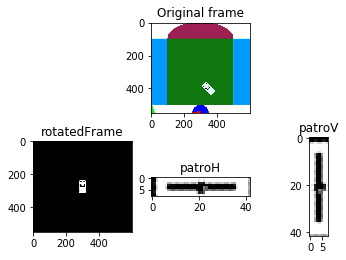

[Visio: contarPunts()]


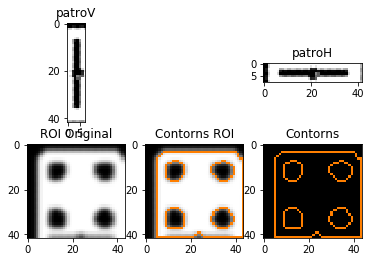

[Visio: contarPunts()]


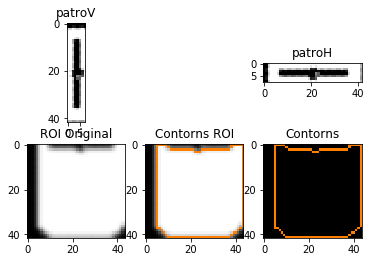

[Visio: getTableData()]
0: [(4.6, 17.490909090909092, 44, 85), [4, 0], 1]
[Visio: updateFrame()]


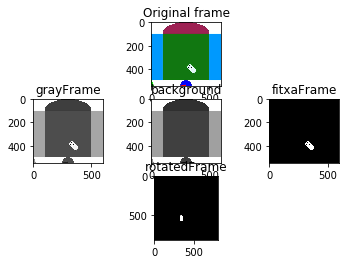

[Visio: contarPunts()]


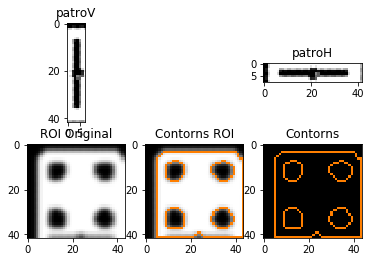

[Visio: contarPunts()]


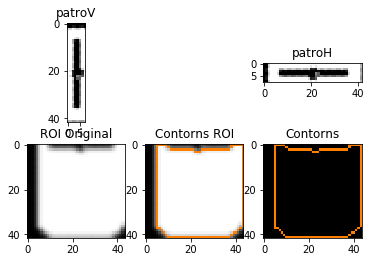

[Visio: contarPunts()]


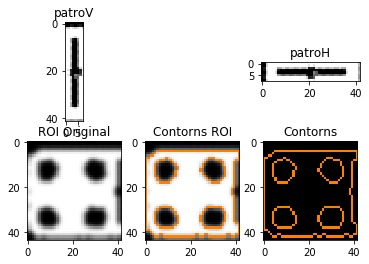

[Visio: contarPunts()]


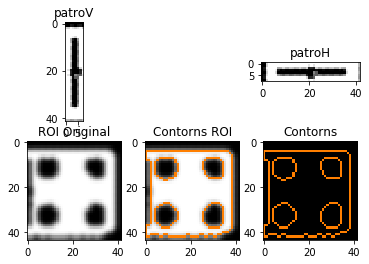

[Visio: getTableData()]
0: [(4.6, 17.490909090909092, 44, 85), [4, 0], 1]
1: [(-6.8, 30.845454545454544, 85, 44), [4, 4], 0]
[Visio: updateFrame()]


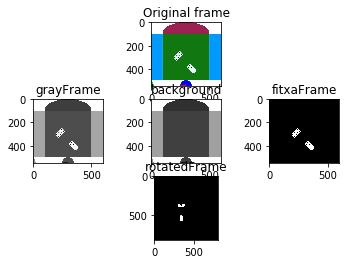

{'maRobot': {}, 'maHuma': {}, 'taulell': {0: [(4.6, 17.490909090909092, 44, 85), [4, 0], 1], 1: [(-6.8, 30.845454545454544, 85, 44), [4, 4], 0]}, 'pou': {}}


In [24]:
import numpy as np
import math
import cv2 as cv
from matplotlib import pyplot as plt

class ModulVisio():
    ###############################################################################################
    def __init__(self, debug = False):
        self.debug = debug
        
        self.empty = True
        self.originalBackground = None
        self.fitxaFrame = None
        self.frame = None
        self.grayFrame = None
        self.rotatedFrame = None
        
        self.patroH = None
        self.patroV = None
        
        self.midaFitxa = [0,0]
        self.rotacioDefecte = 0.0
        
        self.estatPartida = None
    ###############################################################################################
    
    def updateFrame(self,frame,debug=None):
        if debug is not None:
            self.debug = debug
        self.frame = frame
        self.grayFrame = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
        if self.originalBackground is None:
            self.originalBackground = self.grayFrame
        else:
            self.fitxaFrame = cv.absdiff(self.grayFrame,self.originalBackground)
            self.fitxaFrame[self.fitxaFrame<127]=0
            self.fitxaFrame[self.fitxaFrame!=0]=255
            if self.empty:
                self.getFirstFeatures()
            self.rotatedFrame = self.rotate_frame(self.fitxaFrame)
            
            self.getTableData()
        
        if self.debug:
            print('[Visio: updateFrame()]')
            fig, ax = plt.subplots(nrows=3, ncols=3);
            ax[0,0].remove()
            ax[0,1].imshow(self.frame)
            ax[0,1].set_title('Original frame')
            ax[0,2].remove()
            ax[1,0].imshow(self.grayFrame,'gray')
            ax[1,0].set_title('grayFrame')
            ax[1,1].imshow(self.originalBackground,'gray')
            ax[1,1].set_title('background')
            ax[1,2].imshow(self.fitxaFrame,'gray')
            ax[1,2].set_title('fitxaFrame')
            ax[2,0].remove()
            ax[2,1].imshow(self.rotatedFrame,'gray')
            ax[2,1].set_title('rotatedFrame')
            ax[2,2].remove()
            plt.show()     
    ###############################################################################################
    
    def getFirstFeatures(self):
        threshold = cv.GaussianBlur(self.fitxaFrame,(5,5),0)
        contours,hierarchy = cv.findContours(threshold,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)   
        
        max_w = 0
        max_h = 0
        
        for i,c in enumerate(contours):
            if hierarchy[0][i,3]==-1:
                rect = cv.minAreaRect(contours[i])
                if(rect[1][0]>=max_w and rect[1][1]>=max_h):
                    max_w = rect[1][0]
                    max_h = rect[1][1]
                    
                    posicio = rect[0]
                    midaFitxa = rect[1]
                    rotacio = rect[2]

            self.empty = False
                
        if not self.empty:
            rows,cols,_ = self.frame.shape
            
            x = int(posicio[0])
            y = int(posicio[1])
            
            width = int(midaFitxa[0])
            height = int(midaFitxa[1])
            
            centerX = int(cols/2)
            centerY = int(rows/2)
            
            h_gap = centerX - x
            v_gap = centerY - y
            
            # Traslacio
            dst = self.fitxaFrame.copy()
            M = np.float32([[1,0,h_gap],[0,1,v_gap]])
            dst = cv.warpAffine(dst,M,(cols,rows))
            
            # Rotacio
            if width > height: # Horitzontal
                rotacio +=90
            else:
                width, height = height,width
            
            M = cv.getRotationMatrix2D((cols/2,rows/2),rotacio,1.0)
            dst = cv.warpAffine(dst,M,(cols,rows))
            
            self.rotatedFrame = dst
            
            # Definicio patron    
            templateHeight = height * 0.2
            templateWidth = width * 0.5
            
            self.patroH = dst[centerY-int(templateHeight*0.5):centerY+int(templateHeight*0.5), centerX-int(templateWidth*0.5):centerX+int(templateWidth*0.5)]
            self.patroV = self.patroH.transpose()
            self.midaFitxa = [min(width, height),max(width, height)]
            self.rotacioDefecte = rotacio                
        
        if self.debug:
            print('[Visio: getFirstFeatures()]')
            print('Empty:{}; Posicio:{}; mida:{}; rotacio:{};'.format(self.empty,posicio, self.midaFitxa,self.rotacioDefecte))
            fig, ax = plt.subplots(nrows=2, ncols=3);
            ax[0,0].remove()
            ax[0,1].imshow(self.frame)
            ax[0,1].set_title('Original frame')
            ax[0,2].remove()
            ax[1,0].imshow(self.rotatedFrame,'gray')
            ax[1,0].set_title('rotatedFrame')
            ax[1,1].imshow(self.patroH,'gray')
            ax[1,1].set_title('patroH')
            ax[1,2].imshow(self.patroV,'gray')
            ax[1,2].set_title('patroV')
            plt.show()
            
    ###############################################################################################
    def rotate_frame(self, frame):
        if self.rotacioDefecte != 0.0:
            (h,w) = frame.shape[:2]
            (cX,cY) = (w//2,h//2)

            M = cv.getRotationMatrix2D((cX,cY),self.rotacioDefecte,1.0)
            cos = np.abs(M[0,0])
            sin = np.abs(M[0,1])

            nW = int((h*sin)+(w*cos))
            nH = int((h*cos)+(w*sin))

            M[0,2] += (nW/2)-cX
            M[1,2] += (nH/2)-cY

            res = cv.warpAffine(frame,M,(nW,nH))
        else:
            res = frame
        return res
    
    ###############################################################################################
    
    def contarPunts(self,roi):
        roi = cv.GaussianBlur(roi,(5,5),0)
        _,threshold = cv.threshold(roi,127,255,cv.THRESH_BINARY)
        contours, hierarchy = cv.findContours(threshold,cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        punts = 0
        for i,c in enumerate(contours):
            pare = hierarchy[0][i,3]
            if pare != -1:
                punts+=1
        
        if self.debug:
            threshold = np.zeros((threshold.shape[0],threshold.shape[1],3),dtype=np.uint8)
            threshold = cv.drawContours(threshold,contours,-1,(255,127,0),1)
            contoursRoi = np.zeros((roi.shape[0],roi.shape[1],3),dtype=np.uint8)
            contoursRoi[:,:,0] = roi
            contoursRoi[:,:,1] = roi
            contoursRoi[:,:,2] = roi
            contoursRoi = cv.drawContours(contoursRoi,contours,-1,(255,127,0),1)
            print('[Visio: contarPunts()]')
            fig, ax = plt.subplots(nrows=2, ncols=3);
            ax[0][0].imshow(self.patroV,'gray')
            ax[0][0].set_title('patroV')  
            ax[0][1].remove()
            
            ax[0][2].imshow(self.patroH,'gray')
            ax[0][2].set_title('patroH')  
            
            ax[1][0].imshow(roi,'gray')
            ax[1][0].set_title('ROI Original') 
            
            ax[1][1].imshow(contoursRoi,'gray')
            ax[1][1].set_title('Contorns ROI')            
            ax[1][2].imshow(threshold,'gray')
            ax[1][2].set_title('Contorns') 
                       
            plt.show()
        
        return punts
    
    ###############################################################################################
    
    def getTableData(self):
        arrayPatrons = [self.patroH, self.patroV]
        zonaMatch = int(min(self.patroV.shape))
        self.estatPartida = {'maRobot':{},'maHuma':{},'taulell':{},'pou':{}}
        
        found = []
        for patro in arrayPatrons:
            final = self.rotatedFrame.copy()
            w,h = patro.shape[::-1]
            # Template Matching
            res = cv.matchTemplate(self.rotatedFrame,patro,cv.TM_CCOEFF_NORMED)
            thr = 0.8
            loc = np.where(res >= thr)
            for pt in zip(*loc[::-1]):
                # Trobar coordenades sense rotar

                if len(found)==0:
                    same=False
                else:
                    same=False
                    for f in found:
                        if pt[0] in (np.arange(f[0]-zonaMatch, f[0]+zonaMatch)):
                            if pt[1] in (np.arange(f[1]-zonaMatch, f[1]+zonaMatch)):
                                same=True
                                break
                if not same:
                    found.append(pt)
                    top_left = pt
                    bottom_right = (pt[0] + w, pt[1] + h)                
                    top_right = (bottom_right[0],top_left[1])
                    bottom_left = (top_left[0],bottom_right[1])

                    center = (int(top_left[0]+(round((top_right[0]-top_left[0])/2))) ,int(top_left[1]+(round((bottom_left[1]-top_left[1])/2))))


                    orientacio = 1 #h
                    alcada = self.midaFitxa[1]
                    amplada = self.midaFitxa[0]
                    if top_right[0]-top_left[0] < bottom_left[1]-top_left[1]:
                        orientacio=0
                        alcada = self.midaFitxa[0]
                        amplada = self.midaFitxa[1]
                    self.estatPartida['taulell'][len(self.estatPartida['taulell'])] = [(center[0],center[1],amplada,alcada),[0,0],orientacio] 
                    
        for dic in self.estatPartida['taulell']:
            #print(estatPartida['taulell'][dic])
            x,y,w,h = self.estatPartida['taulell'][dic][0]
            puntsA=0
            puntsB=0
            if self.estatPartida['taulell'][dic][2]: # Vertical
                # ROI
                roi = self.rotatedFrame[y-round(h/2) : y,x-round(w/2) : x+round(w/2)] # Superior
                puntsA=self.contarPunts(roi)
                roi = self.rotatedFrame[y : y+round(h/2),x-round(w/2) : x+round(w/2)] # Inferior
                puntsB=self.contarPunts(roi)

            else: # Horitzontal
                # ROI
                roi = self.rotatedFrame[y-round(h/2) : y+round(h/2),x-round(w/2) : x] # Esquerra
                puntsA=self.contarPunts(roi)

                roi = self.rotatedFrame[y-round(h/2) : y+round(h/2),x : x+round(w/2)] # Dreta
                puntsB=self.contarPunts(roi)

            self.estatPartida['taulell'][dic][1]=[puntsA,puntsB]
            rotatedCenter = self.rotate_point((self.estatPartida['taulell'][dic][0][0],self.estatPartida['taulell'][dic][0][1]))
            robotCenter = self.robot_coords(rotatedCenter)
            # id: [[x,y,w,h],[puntsA,puntsB],orientacio]
            self.estatPartida['taulell'][dic][0]=(robotCenter[0],robotCenter[1],self.estatPartida['taulell'][dic][0][2],self.estatPartida['taulell'][dic][0][3])        
        if self.debug:
            print('[Visio: getTableData()]')
            for d in self.estatPartida['taulell']:
                print('{}: {}'.format(d,self.estatPartida['taulell'][d]))
            
    ###############################################################################################                    
    def rotate_point(self,pt):
        angle = (self.rotacioDefecte*math.pi)/180
        ox = self.rotatedFrame.shape[1]/2
        oy = self.rotatedFrame.shape[0]/2
        px, py = pt
        x = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        y = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)   
        x = int(x-((self.rotatedFrame.shape[1]-self.grayFrame.shape[1])/2))
        y = int(y-((self.rotatedFrame.shape[0]-self.grayFrame.shape[0])/2))    
        return (x,y)
    ###############################################################################################
    def robot_coords(self,pt):
        # TODO 
        # midaTaulell 
        max_x=60
        max_y=65
        pt0 = pt[0]-self.grayFrame.shape[1]/2
        pt1 = (pt[1]-self.grayFrame.shape[0])
        
        x = ((pt0*max_x)/self.grayFrame.shape[1])
        y = -((pt1*max_y)/self.grayFrame.shape[0])
        return(x,y)
    
    ###############################################################################################
if __name__ == '__main__':
    frame = cv.imread('cropFrame.jpg')
    v = ModulVisio(True)
    v.updateFrame(frame, False)
    frame = cv.imread('cropFrame2.jpg')
    v.updateFrame(frame,True)
    frame = cv.imread('cropFrame3.jpg')
    v.updateFrame(frame,True)
    print(v.estatPartida)

        

